# Parce que le 2 devenait trop gros

In [1]:
import numpy as np
import pandas as pd
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.document as gdoc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
gdoc.setNoScroll()

data = r'data\pfas_2023_surf_ground_drink.parquet'

<IPython.core.display.Javascript object>

In [2]:
df_num_surf_france = pd.read_parquet(data)
df_db = df_num_surf_france[['lat','lon','pfas_sum']]

dat = gl.Db_fromPanda(df_db)
dat.setLocators(["lon","lat"], gl.ELoc.X)
dat.setLocator("pfas_sum", gl.ELoc.Z)
varioParamOmni = gl.VarioParam.createOmniDirection(npas=70, dpas=0.005, toldis=0.2)
varioexp = gl.Vario(varioParamOmni)
err = varioexp.compute(dat)

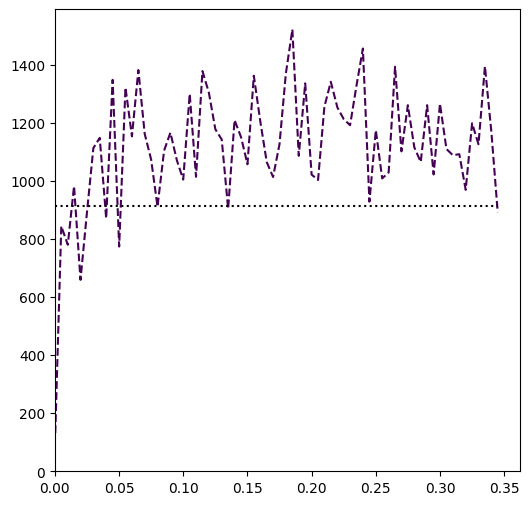

In [3]:
gp.setDefault(dims=[6,6])
gp.varmod(varioexp)
plt.show()

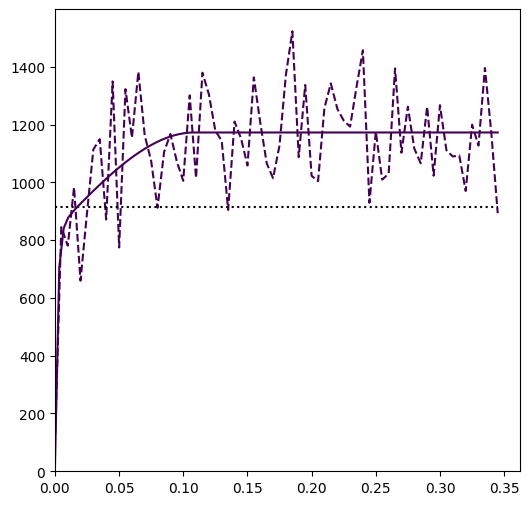

In [4]:
fitmod = gl.Model()
types = [gl.ECov.NUGGET, gl.ECov.EXPONENTIAL ,gl.ECov.SPHERICAL]
err = fitmod.fit(varioexp, types=types)

gp.varmod(varioexp, fitmod)
plt.show()

In [5]:
grid = gl.DbGrid.create(x0=[-5.5,41],dx=[0.1,0.1],nx=[160,110])

In [6]:
dbfmt = gl.DbStringFormat.createFromFlags(flag_extend=True)
grid.display(dbfmt)


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 3
Total number of samples      = 17600

Grid characteristics:
---------------------
Origin :     -5.500    41.000
Mesh   :      0.100     0.100
Number :        160       110

Data Base Extension
-------------------
Coor #1 - Min =     -5.500 - Max =     10.400 - Ext = 15.9
Coor #2 - Min =     41.000 - Max =     51.900 - Ext = 10.9

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2


In [8]:
uniqueNeigh = gl.NeighUnique.create()

In [ ]:
# Krigeage simple

err = gl.kriging(dbin=dat, dbout=grid, model=fitmod, 
              neigh=uniqueNeigh,
              flag_est=True, flag_std=True, flag_varz=False,
              namconv=gl.NamingConvention("SK")
              )

In [9]:
# Krigeage ordinaire

fitmodOK = fitmod.clone()
err = fitmodOK.addDrift(gl.DriftM())

err = gl.kriging(dbin=dat, dbout=grid, model=fitmodOK, 
              neigh=uniqueNeigh,
              flag_est=True, flag_std=True, flag_varz=False,
              namconv=gl.NamingConvention("OK")
              )

In [10]:
# Krigeage ordinaire avec moyenne mobile

lessSmallNeigh = gl.NeighMoving.create(radius=0.5, nmini=5) # 1°~80km ici 40km quintuple du range variogramme
err = gl.kriging(dbin=dat, dbout=grid, model=fitmodOK, neigh=lessSmallNeigh,
              flag_est=True, flag_std=True, 
              namconv=gl.NamingConvention("lessSmall"))

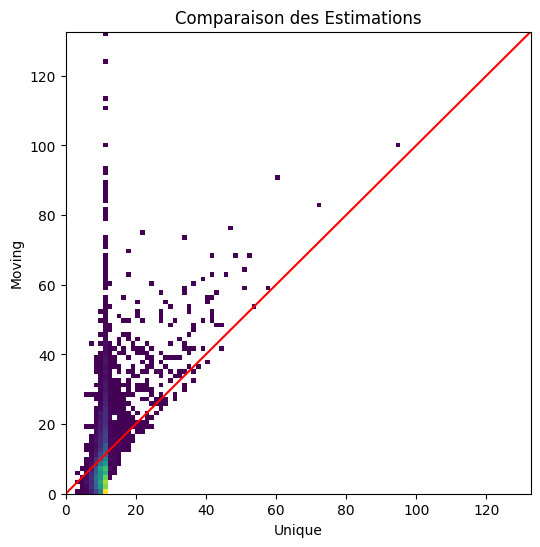

In [15]:
ax = gp.correlation(grid,namex = "OK*estim",namey="lessSmall*estim", 
                    bins=100, bissLine=True, flagSameAxes=True, cmin=1)
ax.decoration(title="Comparaison des Estimations", xlabel="Unique", ylabel="Moving")

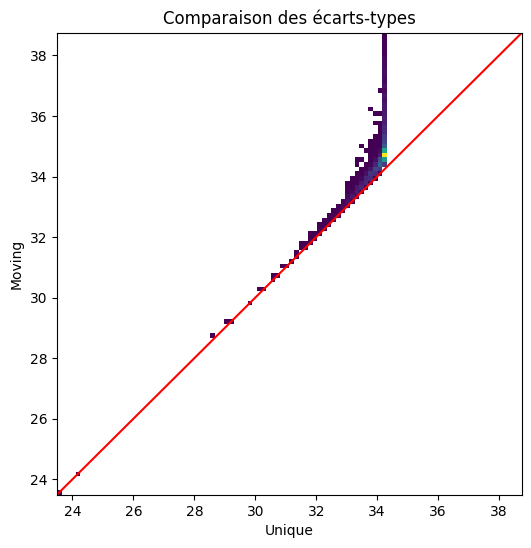

In [16]:
ax = gp.correlation(grid,namex = "OK*stdev",namey="lessSmall*stdev", 
                    bins=100, bissLine=True, flagSameAxes=True, cmin=1)
ax.decoration(title="Comparaison des écarts-types", xlabel="Unique", ylabel="Moving")